In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from fuzzywuzzy import fuzz 
from sklearn.linear_model import LogisticRegression
from transformers import pipeline

1.	Download data on covid tweets from Kaggle: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/download  
Load both the training and testing files into python.


In [2]:
# Read the two csvs and create training and testing dataframes
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')

2.	Plot histogram of sentiment categories in the training dataframe. Hint: Use df[‘Sentiment’] .value_counts().reindex(["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]).plot(kind='bar') to control ordering of categories. Be sure to add title and labels for your axes. Insert your graph here.  


3.	Plot histogram of sentiment categories in the testing dataframe. Insert your graph here.

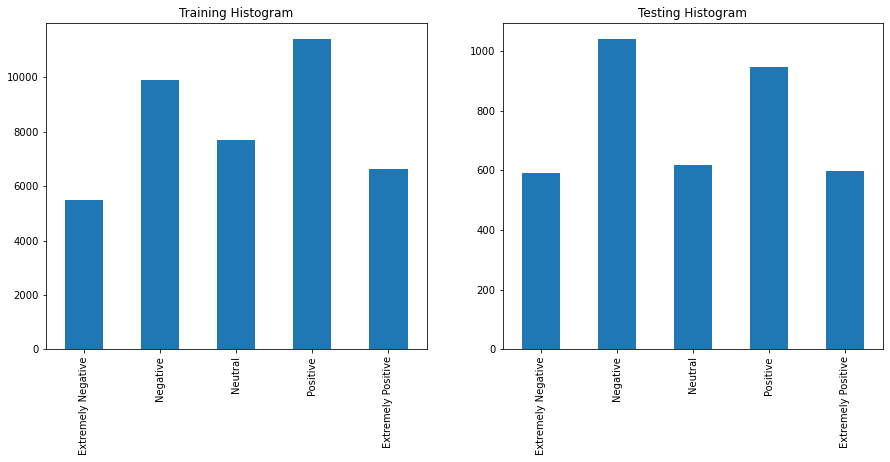

In [3]:
# Initialize the matplotlib object
fig, ax = plt.subplots(1,2, figsize=(15,6))

# Plot the training histogram with the appropriate labels and set the title
train_df['Sentiment'].value_counts().reindex(["Extremely Negative", "Negative", "Neutral", "Positive", 
                                               "Extremely Positive"]).plot(kind='bar', ax=ax[0]) 
ax[0].set_title('Training Histogram')

# Plot the testing histogram with the appropriate labels and set the title
test_df['Sentiment'].value_counts().reindex(["Extremely Negative", "Negative", "Neutral", "Positive", 
                                               "Extremely Positive"]).plot(kind='bar', ax=ax[1]) 
ax[1].set_title('Testing Histogram')


plt.show()

4.	Compare the distributions. Do you think this is a good training/testing split? Why or why not? Write your answer here in 2-3 sentences.  


This looks like a good training/testing split because the histograms look very similar, with spikes at both negative and positive, and dips at the other categories. The training dataset has a higher frequency of positive compared to negative than the testing dataset does, but it doesn't look like a significant difference and the two datasets don't need to be exactly identical.

5.	For this homework, you will be working with the testing dataset only because it is a smaller sample. Furthermore, drop all Neutral labelled tweets. Call this dataframe: df_tweet. How many observations (tweets) does this new dataframe have? Write your answer here.  

df_tweet has 3179 observations remaining.

In [4]:
# Filter out the tweets with Neutral sentiment and print the counts
df_tweet = test_df[test_df['Sentiment']!='Neutral'].reset_index(drop=True)
df_tweet.count()

UserName         3179
ScreenName       3179
Location         2467
TweetAt          3179
OriginalTweet    3179
Sentiment        3179
dtype: int64

6.	To clean the tweets a little, run the following code. NOTE: this code will take between 5-10 minutes to run on a laptop. Explain what each line is doing:

In [5]:
# This creates an empty list to store the new clean tweets in
cleantweet=[]

# this loops through all the tweets in the dataframe df_tweet
for i in range(len(df_tweet)):
    # This gets the tweet from the dataframe
    tweet=df_tweet['OriginalTweet'][i]
    
    # These replace the given characters ('\r', '\n', '. ', and ', ' with a space)
    tweet=tweet.replace('\r',' ')
    tweet=tweet.replace('\n',' ')
    tweet=tweet.replace('.  ',' ')
    tweet=tweet.replace(', ',' ')
    
    # This splits each row on the spaces to create a list of words
    tokens = tweet.split(' ')
    
    # This creates empty lists to store the hashtags and words
    tweet_hashtags=[]
    tweet_token=[]
    
    # This loops through all the words in the word list created from tweet.split
    for t in tokens:
        
        # This checks if the word contains the hyperlink since they all have 'https:', and if it doesn't then it's
        # added to the new list of words
        if "https:" not in t:
            tweet_token.append(t)
            
    # This adds the word to the clean tweet list and joins all the words from the list to reconstruct the 
    # tweet from the list of words, and it makes them all lowercase
    cleantweet.append(" ".join(tweet_token).lower())
    
# This creates a new column from the list of cleaned tweets
df_tweet['clean tweet']= cleantweet

In [6]:
#### Below Takes a few min to run. 5-10 min. ####

# This sets the similarity threshold for dropping the tweet
similar_level=85 

# This creates an empty list to store indices of tweets that are to be deleted
duplicate_index = []

# This loops throuhg all the tweets in df_tweet except the last one
for original in range(len(df_tweet)-1): 
    if original not in duplicate_index:
        
        # If the tweet is not in the duplicate index, then loop through all the tweets starting with the current
        # one through the end of the dataframe
        for compared in range(original+1, len(df_tweet)): 
            
            # If the compared tweet isn't in the duplicate index, then check how similar the compared and original
            # tweets are. If the ratio is greater than 85, add the compared tweet to the duplicate index
            # to get dropped
            if compared not in duplicate_index:                
                if fuzz.ratio(df_tweet['clean tweet'][original], 
                              df_tweet['clean tweet'][compared]) >= similar_level: 
                    duplicate_index.append(compared)
                    
# The point of the above code is to drop tweets that are too similar from the dataframe
            
# This drops the tweets that are too similar and resets in the index of the dataframe
df_tweet.drop(duplicate_index, inplace=True)
df_tweet.reset_index(drop=True,inplace=True)

7.	Make a list of hashtags for each tweet.

In [7]:
# Initialize an empty list to store the hashtages
hashtags = []

# Loop through the clean tweets and split up each word
for index, item in df_tweet.iterrows():
    words = item['clean tweet'].split(" ")
    
    # Initialize and empty list for the tags
    tags = []
    # Loop throuhg every word in each tweet and if it contains a "#", add it to tags
    for w in words:
        if "#" in w:
            tags.append(w)
    
    # Add each list of tags to hashtags
    hashtags.append(tags)
            
# Set the new columns equal to hashtags
df_tweet['hashtags'] = hashtags

8.	What are the top 20 most used hashtags? Insert the list of hashtags and how many time each hashtag occur here. 

In [8]:
# Use the counter to count each occurance of each hashtag and print the top 20 most common
tag_counts = Counter(chain.from_iterable(hashtags))
tag_counts.most_common(20)

[('#covid_19', 1215),
 ('#coronavirus', 1021),
 ('#covid19', 226),
 ('#coronaviruspandemic', 176),
 ('#covid2019', 141),
 ('#coronaoutbreak', 127),
 ('#coronapocalypse', 101),
 ('#covid?19', 88),
 ('#panicbuying', 83),
 ('#coronavirusupdate', 49),
 ('#coronavirusoutbreak', 43),
 ('#corona', 41),
 ('#toiletpaper', 34),
 ('#retail', 29),
 ('#pandemic', 28),
 ('#coronavirusupdates', 28),
 ('#coronavirus.', 27),
 ('#covid', 24),
 ('#food', 23),
 ('#lockdown', 23)]

9.	Using the ‘clean tweet’ variable from problem 6, create term frequency vector representation for all tweets. That is, make a document-term matrix where each document is a tweet and the terms are all the vocabulary from the tweet dataset. Hint: use TfidfVectorizer().fit_transform(). Call your document term matrix X. It should come out as a scipy.sparse.csr.csr_matrix object.   

a.	What are the dimensions of your matrix? Write that out here.  
The dimensions are 3138 rows by 11074 columns, or 3138 documents with 11074 unique words



In [9]:
# Initialize and Tfidf vectorizer and fit it to the clean tweets
tv = TfidfVectorizer()
X = tv.fit_transform(df_tweet['clean tweet'])

# Display the result to find the dimensions
X

<3138x11074 sparse matrix of type '<class 'numpy.float64'>'
	with 93976 stored elements in Compressed Sparse Row format>

10.	Use .get_feature_names() to make a list of the vocabulary and call it “features”.   
a.	Is this list alphabetized automatically? Write your answer here:  
Yes, this list is automatically sorted into alphabetical order  

b.	What is the word associated with index 1680? Write your answer here:  
'caramel' is associated with the index 1680


In [10]:
# Access the features using get_feature_names and print out a subset to check if they are in alphabetical order
features = tv.get_feature_names()
print(features[550:575])

# Display the item at index 1680
features[1680]

['aka', 'aka_layla', 'akin', 'akin_adesina', 'al', 'alabama', 'alarm', 'alas', 'alaska', 'albeit', 'albert', 'alberta', 'albertarecession', 'alcohol', 'alcohol_based_product', 'alcohols', 'alcoholâ', 'aldi', 'aldiuk', 'aldiusa', 'alert', 'alerting', 'alertness', 'alex', 'alex_carrick']


'caramel'

11.	Calculate the pairwise similarity between all tweets using cosine similarity. Hint: use the cosine_similarity() command from sklearn and then change it to a dataframe called df_cossim.

In [11]:
# Create the similarity dataframe with the tweet indices as column labels
df_cossim = pd.DataFrame(cosine_similarity(X), df_tweet.index)

12.	Run the following code and explain each step:

In [12]:
# This creates a dataframe of the values from the triangle under the diagonal from the cosine similarity dataframe 
df_cossim_tri = pd.DataFrame(np.tril(df_cossim.values, k=-1))

# This flattens the dataframe so each comparison is it's own row, so we can easily rank the similarity scores
df_rank = df_cossim_tri.unstack().reset_index()

# This names the columns of the dataframe
df_rank.columns = ['row', 'column', 'similarity']

13.	Which pairs of tweets have the top 10 highest similarity scores? Below include a table with the tweet pairs and their corresponding similarity score. Hint: sort the df_rank dataframe over similarity.

In [13]:
# Sort the similarity values in descending order
df_rank.sort_values('similarity', ascending=False).head(10)

,row,column,similarity
2646686,843,1352,0.852782
2546270,811,1352,0.852692
560513,178,1949,0.823141
4244517,1352,1941,0.814792
7452073,2374,2461,0.813846
182325,58,321,0.812643
2546388,811,1470,0.811657
2546859,811,1941,0.804707
2545761,811,843,0.801811
8039048,2561,2630,0.795819


In [14]:
# Print out each of the 10 pairs to do a manual check of the similarities
print(df_tweet['clean tweet'][843])
print(df_tweet['clean tweet'][1352])
print()
print(df_tweet['clean tweet'][811])
print(df_tweet['clean tweet'][1352])
print()
print(df_tweet['clean tweet'][178])
print(df_tweet['clean tweet'][1949])
print()
print(df_tweet['clean tweet'][1352])
print(df_tweet['clean tweet'][1941])
print()
print(df_tweet['clean tweet'][2374])
print(df_tweet['clean tweet'][2461])
print()
print(df_tweet['clean tweet'][58])
print(df_tweet['clean tweet'][321])
print()
print(df_tweet['clean tweet'][811])
print(df_tweet['clean tweet'][1470])
print()
print(df_tweet['clean tweet'][811])
print(df_tweet['clean tweet'][1941])
print()
print(df_tweet['clean tweet'][811])
print(df_tweet['clean tweet'][843])
print()
print(df_tweet['clean tweet'][2561])
print(df_tweet['clean tweet'][2630])

call your rep amp senators today amp demand they pass the bill it contains free testing 14 days paid sick leave 3 months paid family leave expanded unemployment insurance amp food security medicaid funds lives are on the line 202 224 3121
call your representatives today and demand they pass the #familiesfirst coronavirus bill. #coronavirus    - free testing   - 14 days paid sick leave   - 3 months paid family leave   - expanded unemployment insurance &amp; food security   - medicaid funds   lives are on the line. (202) 224-3121

call now 202 224 3121 and demand congress pass the bill   free testing   14 days paid sick leave   3 months paid family leave   expanded unemployment insurance and food security   medicaid funds
call your representatives today and demand they pass the #familiesfirst coronavirus bill. #coronavirus    - free testing   - 14 days paid sick leave   - 3 months paid family leave   - expanded unemployment insurance &amp; food security   - medicaid funds   lives are on 

14.	Spend 3-5 sentences describing what seems to make sense in the similarity matching. What doesn’t make sense? If you wanted to improve matching, what steps would you take now? If you would need to do more cleaning of the data, what would you want to do?  


It seems that tweets that repeat the same phrases are more likely to have higher similairty scores, which makes sense. For example, the only differences between the top two most similar tweets are some different abbreviations and puncuation. Since these tweets are nearly identical, it seems that the similarity score should actually be higher. This could be achieved by removing more kinds of punctuation than just periods and commas and by stemming certain words, especially those that are often abbreviated over tweets like 'reps' for 'representatives'. 

15.	Make a new variable that has binary sentiment (positive=1 and negative=0) where a sentiment of positive and extremely positive is now 1, and then negative and extremely negative is now 0. 

In [15]:
# Initialize and empty list to store the binary sentiment rating
bin_sent = []

# Loop through each item in the sentiment column and add 1 to bin_sent if the sentiment is Ppositive or
# extremely positive, otherwise add 0
for index, item in df_tweet.iterrows():
    if 'Positive' in item['Sentiment']:
        bin_sent.append(1)
    else:
        bin_sent.append(0)
        
# Create the new column bin_sent from the list of binary sentiment
df_tweet['bin_sent'] = bin_sent

16.	Run a logit lasso regression with binary sentiment as the output variable and your document term matrix as your inputs. 

In [16]:
# Create the document term matrix and save it as x, and save the response variable, binary sentiment, as y
x = pd.DataFrame(X.toarray(), df_tweet.index)
y = df_tweet['bin_sent']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1680)

# The C values to loop through
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Empty list to store accuracies
acc = []
# Loop through each C, fit the model, and store the accuracy and C value as a tuple
for c in Cs:
    logit = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=c)
    model = logit.fit(X_train,y_train)
    acc.append((model.score(X_test,y_test), c))
    
print(acc)
# C = 10 gives the best accuracy of 0.7691

[(0.49363057324840764, 0.001), (0.49363057324840764, 0.01), (0.49363057324840764, 0.1), (0.7101910828025477, 1), (0.7691082802547771, 10), (0.767515923566879, 100), (0.7627388535031847, 1000)]


16 d.	Run the following code and explain each line

In [17]:
# Fit the model with the optimal C value (C=10) and save the coefficients
logit = LogisticRegression(penalty='l1', solver='liblinear', random_state=1680, C=10)
model = logit.fit(x,y)
coefs = model.coef_

# This creates a dataframe with every word and its coefficient
df_coef = pd.DataFrame({'word': features, 'coef': coefs[-1].tolist()})

# This adds a column to the coefficient dataframe that is the absolute value of the coefficient
df_coef['abs coef']= df_coef['coef'].abs()

# This adds a column to the tweet dataframe that is the predicted sentiment of the tweet
df_tweet['logitlasso predicted sentiment'] = model.predict(x)

17.	What are the top 20 most important words for predicting class? These will be the largest coefficients in absolute value. Hint: sort df_coef. Print those top 20 words and their coefficients here.

In [18]:
# Top 20 words
df_coef.sort_values('abs coef', ascending=False).head(20)

,word,coef,abs coef
8222,resource,-24.903412,24.903412
4546,hand,23.218213,23.218213
7107,panic,-22.791281,22.791281
2602,crisis,-22.565036,22.565036
4413,great,21.988188,21.988188
9614,suspended,-21.494135,21.494135
1207,best,21.484082,21.484082
4095,free,20.436642,20.436642
8470,safety,20.272930,20.272930
7511,positive,19.637654,19.637654


18.	What are the top 10 “positive words”? The top 10 “negative words”? Print the top 10 words of each sentiment and their coefficients here.

In [19]:
# Top 10 Positive
display(df_coef.sort_values('coef', ascending=False).head(10))

# Top 10 Negative
display(df_coef.sort_values('coef').head(10))

,word,coef,abs coef
4546,hand,23.218213,23.218213
4413,great,21.988188,21.988188
1207,best,21.484082,21.484082
4095,free,20.436642,20.436642
8470,safety,20.272930,20.272930
7511,positive,19.637654,19.637654
10997,yeah,19.010867,19.010867
5755,like,18.970383,18.970383
4130,friends,18.538128,18.538128
4575,happy,18.511778,18.511778


,word,coef,abs coef
8222,resource,-24.903412,24.903412
7107,panic,-22.791281,22.791281
2602,crisis,-22.565036,22.565036
9614,suspended,-21.494135,21.494135
9473,stupid,-18.843976,18.843976
10952,wrong,-17.942282,17.942282
7165,partner,-17.677614,17.677614
8912,sick,-17.462783,17.462783
3843,ffs,-17.168007,17.168007
4667,hell,-16.892468,16.892468


19.	Here you will use the HuggingFace package with pre-trained algorithms. This pipeline takes string text as input, not tokens. So you will be using your dataframe from question 5. First work with the default model for sentiment analysis from HuggingFace which is the DistilBERT base uncased model finetuned with SST-2.  


a.	Run the following code  


b.	Paste the output from the code here:


In [20]:
# Setup the default pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Print the results of running the pipeline on the original tweets
print(sentiment_pipeline(df_tweet['OriginalTweet'][0:10].tolist()))

# Print the original tweets with defined breaks for readability
for i in range(len(df_tweet['OriginalTweet'][0:10].tolist())):
    print(df_tweet['OriginalTweet'][0:10].tolist()[i])
    print('/n/break ' + str(i))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


[{'label': 'NEGATIVE', 'score': 0.999046266078949}, {'label': 'NEGATIVE', 'score': 0.9964587092399597}, {'label': 'POSITIVE', 'score': 0.9808228611946106}, {'label': 'NEGATIVE', 'score': 0.9943122863769531}, {'label': 'NEGATIVE', 'score': 0.9957156777381897}, {'label': 'NEGATIVE', 'score': 0.9990513920783997}, {'label': 'POSITIVE', 'score': 0.9799405932426453}, {'label': 'NEGATIVE', 'score': 0.9910359382629395}, {'label': 'NEGATIVE', 'score': 0.9969425797462463}, {'label': 'NEGATIVE', 'score': 0.9989578723907471}]
TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1
/n/break 0
When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY
/n/break 1
Find out how you can protect yourse

c.	How does this compare to the original sentiment label? Print out the original sentiment label for the first 10 tweets.  

In [21]:
# Display the original sentiment labels for the first 10 tweets
df_tweet['Sentiment'][0:10]

0    Extremely Negative
1              Positive
2    Extremely Positive
3              Negative
4              Positive
5    Extremely Negative
6    Extremely Positive
7              Positive
8    Extremely Negative
9    Extremely Negative
Name: Sentiment, dtype: object

d.	Do you think the hand coded labels (the original sentiment labels) or the ones predicted by the pre-trained algorithm make more sense? Explain your answer using the text from the tweets as evidence. Why do you think there are differences?  

The hand coded labels mark tweets at indices 0,3,5,8,9 as negative, and tweets 1,2,4,6,7 as positive. The pre-trained algorithm marks tweets 0,1,3,4,5,7,8,9 as negative and tweets 2,6 as positive, so the two labelling methods disagree on tweets 1,4 and 7. For tweet 1, the pre-trained label makes more sense, but for tweet 7, the hand coded one does. Tweet 1 is talking about rising prices of hand sanitizer, which is certainly a negative thing especially during a pandemic. Tweet 7 is an advertisement emphasizing low prices, which is a good thing, but the tweet has a covid hashtag, which is probably severely negatively skewing the sentiment for the pre-trained model. The sentiment of tweet 4 seems pretty ambiguous as it's mostly just expressing an observation, and there are both positive things, like voting, and negative things, like coronavirus, mentioned in the tweet. The coronavirus mention is probably why the pre-trained model rates it as negative, while the person's tone in the attached video is more upbeat which is probably why it earns the hand coded label of positive. The latter is probably the more correct reading of the tweet.

The ratings of all the other tweets seem to make sense for both models except 6. The negative tweets are almost all about shopping crises brought on by the beginning of covid, while the positive tweet is about protecting yourself and your family from covid. Both models seems to miss the sarcasm implied (and the included picture) of tweet 6, which is again about a shopping crisis.

Overall, the hand coded labels seem to make slightly more sense, but neither model is perfect and the pre-trained model still performs very well.

20.	Look at the other pretrained models in HuggingFace at https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads&search=sentiment. 

a.	Which pretrained models would be appropriate for analyzing the Covid Tweets dataset? Name the model you would use, broadly how it was trained, and your reasoning for why you would pick it.  

Any model recently trained (i.e. post Covid-19) on large samples of English tweets should suffice for analyzing the Covid Tweets dataset. I chose the cardiffnlp/twitter-roberta-base-sentiment-latest, which was trained on 124 million tweets from January 2018 to December 2021, because this includes the entire context of the Covid crises so it will probably have the most accurate understanding of how mentions of covid relate to sentiment.



b.	Take the code from 19a. and run the sentiment analysis for the same 10 tweets. Print the predicted labels here:

In [22]:
# Set up the roberta-base-sentiment model in the pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest",
                             tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Print the results of running the pipeline on the original tweets
print(sentiment_pipeline(df_tweet['OriginalTweet'][0:10].tolist()))

# Print the original tweets with defined breaks for readability
for i in range(len(df_tweet['OriginalTweet'][0:10].tolist())):
    print(df_tweet['OriginalTweet'][0:10].tolist()[i])
    print('/n/break ' + str(i))

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'Negative', 'score': 0.5433744788169861}, {'label': 'Negative', 'score': 0.7914344072341919}, {'label': 'Neutral', 'score': 0.8296441435813904}, {'label': 'Negative', 'score': 0.5996304154396057}, {'label': 'Neutral', 'score': 0.7118917107582092}, {'label': 'Negative', 'score': 0.848591685295105}, {'label': 'Positive', 'score': 0.6536583304405212}, {'label': 'Neutral', 'score': 0.5237236618995667}, {'label': 'Negative', 'score': 0.5035489797592163}, {'label': 'Negative', 'score': 0.5594478249549866}]
TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1
/n/break 0
When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY
/n/break 1
Find out how you can protect yourself 

c.	How do the predicted labels here compare to those from question 19? Explain why you think there are differences/similarities.   

This model assigns a negative sentiment for tweets 0,1,3,5,8,9, neutral for tweets 2,4,7 and positive for tweet 6.
I think the neutral label certainly makes more sense for 4 and is probably reasonable for tweets 2 and 7 as well. The negative tweets all use obviously negative words like "panic", or "beware", or "fear", which is why they are still marked negative with this model. In the time since covid started, the word covid itself has become less of an inherently negative word and instead more neutral, which explains why this model marks tweets 4 and 7 as neutral instead of negative like the previous one. Again, the model seems to the miss the sarcasm in tweet 6 and mark it as positive. This might be because Dublin has a positive association in the training set, which could be skewing both models when there aren't any obviously negative words in the tweet (the default model documentation noted this could happen with certain country names).
